## Feature Engineering

In [1]:
#Run imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols

In [2]:
#Run imports
from sklearn.model_selection import (train_test_split,cross_val_score)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge, ElasticNet, ElasticNetCV
import sklearn.metrics as metrics

In [3]:
#Expand
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [4]:
#Import data
train = pd.read_csv('../datasets/train_clean.csv', keep_default_na=False)

In [5]:
#Drop Unnamed:0 column
train.drop(columns='Unnamed: 0', inplace=True)

In [6]:
#Check
#pd.set_option('display.max_columns', 500)
train.head()

,saleprice,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod/add,yr_sold,mas_vnr_area,bsmtfin_sf_1,total_bsmt_sf,frst_flr_sf,sec_flr_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,totrms_abvgrd,fireplaces,garage_area,wood_deck_sf,open_porch_sf,screen_porch,neighborhood,exter_qual,exter_cond,bsmt_exposure,kitchen_qual,garage_finish,heating_qc,fireplace_qu
0,130500,0.0,13517,6,8,1976,2005,2010,289.0,533.0,725.0,725,754,1479,0.0,0.0,2,1,3,6,0,475.0,0,44,0,Sawyer,Gd,TA,No,Gd,RFn,Ex,None
1,220000,43.0,11492,7,5,1996,1997,2009,132.0,637.0,913.0,913,1209,2122,1.0,0.0,2,1,4,8,1,559.0,0,74,0,SawyerW,Gd,TA,No,Gd,RFn,Ex,TA
2,109000,68.0,7922,5,7,1953,2007,2010,0.0,731.0,1057.0,1057,0,1057,1.0,0.0,1,0,3,5,0,246.0,0,52,0,NAmes,TA,Gd,No,Gd,Unf,TA,None
3,174000,73.0,9802,5,5,2006,2007,2010,0.0,0.0,384.0,744,700,1444,0.0,0.0,2,1,3,7,0,400.0,100,0,0,Timber,TA,TA,No,TA,Fin,Gd,None
4,138500,82.0,14235,6,8,1900,1993,2010,0.0,0.0,676.0,831,614,1445,0.0,0.0,2,0,3,6,0,484.0,0,59,0,SawyerW,TA,TA,No,TA,Unf,TA,None


### Feature Reduction/Combination

Based on our previous observations and work, there are some features that we want to change their format  

For example, the current 'year_built' does not serve a purpose, and acts like a categorical variable instead!   
Let's change them to 'age' where it is easier to compute and interpret!

In [7]:
#Convert year_remod/add into 'age' using year sold minus year remodelled
#This gives us a better continuous series to be used in our modelling
train['remod_age'] = train['yr_sold'] - train['year_remod/add']
train['built_age'] = train['yr_sold'] - train['year_built']

We also noted that we want to sum up all baths:

In [8]:
#We also want to add up total number of bathrooms (instead of using 4, just use 1 column)
train['total_bath'] = train['full_bath'] + train['half_bath'] +\
train['bsmt_full_bath'] + train['bsmt_half_bath']

In [9]:
#Drop all redundant columns
train.drop(columns=['year_built','year_remod/add','yr_sold',
                    'full_bath','half_bath','bsmt_full_bath','bsmt_half_bath'], inplace=True)

We also want to try to further classify our neighborhoods and try modelling  
if result are poor, we may consider to re-classify  
we will consolidate down to different class tiers.   
**tier1 (most exp) --> tier7 (least exp)**

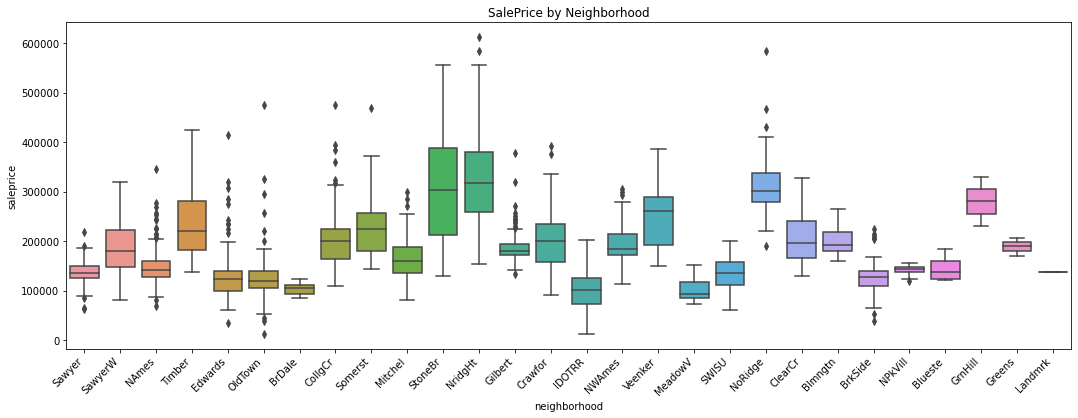

In [10]:
#plot neighborhood to see relationship to saleprice
plt.figure(figsize=(18,6))
sns.boxplot(x='neighborhood', y='saleprice', data=train)
plt.xticks(rotation = 45, ha = 'right')
plt.title('SalePrice by Neighborhood');

In [11]:
#Let's further classify down the neighborhoods into 7 categories
tier = train.groupby('neighborhood')['saleprice'].mean().sort_values(ascending=False)
tier

neighborhood
NridgHt    322831.352459
StoneBr    316613.638889
NoRidge    316294.125000
GrnHill    280000.000000
Veenker    253570.588235
Timber     242775.851064
Somerst    227183.900000
Crawfor    205901.211268
ClearCr    205328.727273
CollgCr    202497.216667
Blmngtn    200417.681818
NWAmes     194619.022989
Gilbert    189228.387931
Greens     188666.666667
SawyerW    187760.160920
Mitchel    167656.707317
NAmes      145905.816129
Blueste    144566.666667
NPkVill    140476.470588
Sawyer     137181.909910
Landmrk    137000.000000
SWISU      134758.875000
Edwards    129905.787234
BrkSide    127022.697368
OldTown    125276.300613
BrDale     103371.052632
IDOTRR     101103.188406
MeadowV    100231.250000
Name: saleprice, dtype: float64

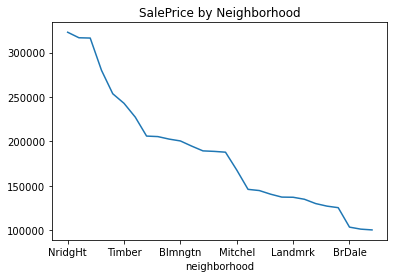

In [12]:
#SalePrice by neighborhood
tier.plot();
plt.title('SalePrice by Neighborhood');

In [13]:
#Map the changes into tier_one, tier_two, tier_three.... seven
train['neighborhood'] = train['neighborhood'].map({'Blmngtn':'tier_three',
       'Blueste':'tier_five',
       'BrDale':'tier_seven',
       'BrkSide':'tier_six',
       'ClearCr':'tier_two',
       'CollgCr':'tier_three',
       'Crawfor':'tier_three',
       'Edwards':'tier_six',
       'Gilbert':'tier_four',
       'Greens':'tier_four',
       'GrnHill':'tier_one',
       'IDOTRR':'tier_seven',
       'Landmrk':'tier_six',
       'MeadowV':'tier_seven',
       'Mitchel':'tier_four',
       'NAmes':'tier_five',
       'NoRidge':'tier_one',
       'NPkVill':'tier_five',
       'NridgHt':'tier_one',
       'NWAmes':'tier_three',
       'OldTown':'tier_seven',
       'SWISU':'tier_six',
       'Sawyer':'tier_five',
       'SawyerW':'tier_four',
       'Somerst':'tier_two',
       'StoneBr':'tier_one',
       'Timber':'tier_two',
       'Veenker':'tier_two'})

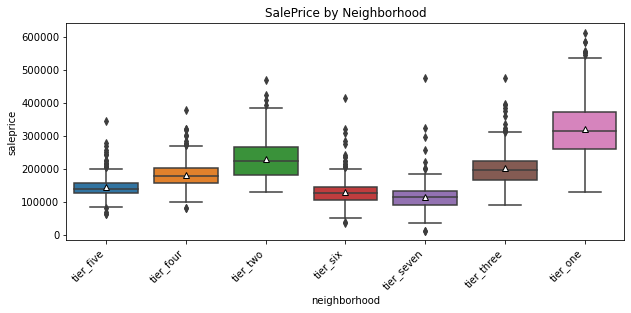

In [14]:
#Check
#re-plot neighborhood to see relationship to saleprice
plt.figure(figsize=(10,4))
sns.boxplot(x='neighborhood', y='saleprice', data=train, showmeans=True, 
                meanprops={'markerfacecolor':'white','markeredgecolor':'black'})
plt.xticks(rotation = 45, ha = 'right')
plt.title('SalePrice by Neighborhood');

Now we have fewer categories (tier_one with highest mean, and tier_seven with the least mean)

In [15]:
#Check df
pd.set_option('display.max_columns', 50)
train.head(5)

,saleprice,lot_frontage,lot_area,overall_qual,overall_cond,mas_vnr_area,bsmtfin_sf_1,total_bsmt_sf,frst_flr_sf,sec_flr_sf,gr_liv_area,bedroom_abvgr,totrms_abvgrd,fireplaces,garage_area,wood_deck_sf,open_porch_sf,screen_porch,neighborhood,exter_qual,exter_cond,bsmt_exposure,kitchen_qual,garage_finish,heating_qc,fireplace_qu,remod_age,built_age,total_bath
0,130500,0.0,13517,6,8,289.0,533.0,725.0,725,754,1479,3,6,0,475.0,0,44,0,tier_five,Gd,TA,No,Gd,RFn,Ex,None,5,34,3.0
1,220000,43.0,11492,7,5,132.0,637.0,913.0,913,1209,2122,4,8,1,559.0,0,74,0,tier_four,Gd,TA,No,Gd,RFn,Ex,TA,12,13,4.0
2,109000,68.0,7922,5,7,0.0,731.0,1057.0,1057,0,1057,3,5,0,246.0,0,52,0,tier_five,TA,Gd,No,Gd,Unf,TA,None,3,57,2.0
3,174000,73.0,9802,5,5,0.0,0.0,384.0,744,700,1444,3,7,0,400.0,100,0,0,tier_two,TA,TA,No,TA,Fin,Gd,None,3,4,3.0
4,138500,82.0,14235,6,8,0.0,0.0,676.0,831,614,1445,3,6,0,484.0,0,59,0,tier_four,TA,TA,No,TA,Unf,TA,None,17,110,2.0


## OLS StatsModel

We will try using statsmodel to check Pvalue of our predictors

In [16]:
#run OLS stats model
f_rev = 'saleprice~C(neighborhood)+C(exter_qual)+C(exter_cond)+C(bsmt_exposure)+\
C(garage_finish)+C(kitchen_qual)+C(heating_qc)+C(fireplace_qu)+\
lot_frontage+lot_area+overall_qual+overall_cond+mas_vnr_area+bsmtfin_sf_1+\
total_bsmt_sf+frst_flr_sf+sec_flr_sf+gr_liv_area+bedroom_abvgr+totrms_abvgrd+\
fireplaces+garage_area+wood_deck_sf+open_porch_sf+screen_porch+\
remod_age+built_age+total_bath'
model_rev = ols(formula=f_rev, data=train).fit()
model_rev.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     413.0
Date:                Fri, 05 Mar 2021   Prob (F-statistic):               0.00
Time:                        16:48:39   Log-Likelihood:                -23396.
No. Observations:                2041   AIC:                         4.690e+04
Df Residuals:                    1989   BIC:                         4.719e+04
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                      5.336e+04   1.32e+04      4.046      0.000    2.75e+04    7.92e+04
C(neighborhood)[T.tier_four]   1001.4224   2147.210      0.466      0.641   -3209.594    5212.439
C(neighborhood)[T.tier_one]    3.452e+04   2918.633     11.826      0.000    2.88e+04    4.02e+04
C(neighborhood)[T.tier_seven] -5525.5964   2218.900     -2.490      0.013   -9877.208   -1173.985
C(neighborhood)[T.tier_six]    -194.5639   2025.967     -0.096      0.924   -4167.805    3778.677
C(neighborhood)[T.tier_three]  5165.3600   1963.795      2.630      0.009    1314.049    9016.671
C(neighborhood)[T.tier_two]    1.184e+04   2502.275      4.732      0.000    6933.773    1.67e+04
C(exter_qual)[T.Fa]           -3.705e+04   6777.305     -5.466      0.000   -5.03e+04   -2.38e+04
C(exter_qual)[T.Gd]           -3.279e+04   3585.373     -9.145      0.000   -3.98e+04   -2.58e+04
C(exter_qual)[T.TA]           -3.811e+04   4090.448     -9.318      0.000   -4.61e+04   -3.01e+04
C(exter_cond)[T.Fa]           -4676.1980   9879.783     -0.473      0.636   -2.41e+04    1.47e+04
C(exter_cond)[T.Gd]           -3657.7312   9106.836     -0.402      0.688   -2.15e+04    1.42e+04
C(exter_cond)[T.Po]           -1.085e+04   2.07e+04     -0.524      0.600   -5.14e+04    2.97e+04
C(exter_cond)[T.TA]           -1637.1455   9045.846     -0.181      0.856   -1.94e+04    1.61e+04
C(bsmt_exposure)[T.Gd]         1.427e+04   2306.739      6.185      0.000    9742.877    1.88e+04
C(bsmt_exposure)[T.Mn]        -4338.5634   2364.507     -1.835      0.067   -8975.733     298.607
C(bsmt_exposure)[T.No]        -2905.3342   1634.336     -1.778      0.076   -6110.524     299.856
C(garage_finish)[T.None]       1355.1755   3308.031      0.410      0.682   -5132.393    7842.744
C(garage_finish)[T.RFn]       -5708.0386   1512.012     -3.775      0.000   -8673.331   -2742.746
C(garage_finish)[T.Unf]       -2931.4122   1758.177     -1.667      0.096   -6379.473     516.649
C(kitchen_qual)[T.Fa]         -2.993e+04   4893.681     -6.116      0.000   -3.95e+04   -2.03e+04
C(kitchen_qual)[T.Gd]         -2.892e+04   2722.967    -10.620      0.000   -3.43e+04   -2.36e+04
C(kitchen_qual)[T.TA]         -3.115e+04   3114.020    -10.003      0.000   -3.73e+04    -2.5e+04
C(heating_qc)[T.Fa]           -2137.6127   3254.200     -0.657      0.511   -8519.611    4244.385
C(heating_qc)[T.Gd]           -2434.3719   1643.393     -1.481      0.139   -5657.324     788.580
C(heating_qc)[T.Po]           -1.304e+04    1.5e+04     -0.867      0.386   -4.25e+04    1.65e+04
C(heating_qc)[T.TA]           -6944.4947   1548.938     -4.483      0.000   -9982.205   -3906.784
C(fireplace_qu)[T.Fa]         -9551.9237   5496.703     -1.738      0.082   -2.03e+04    1227.976
C(fireplace_qu)[T.Gd]         -2059.7432   44

**So we can observe from our OLS model that the P-value for 'total_bath' is too high**  
<span style='color:blue'>this means that 'total_bath' is not statistically significant in our current model!<span> 

Previously in HeatMap under Part1, we observed that totrms_abvgrd and gr_liv_area are highly correlated.  
It might be hard to decide just now which feature to drop, and now with OLS model's help,   
we can decide to drop totrms_abvgrd! and also open_porch_sf!

In [17]:
#run OLS stats model
f_rev = 'saleprice~C(neighborhood)+C(exter_qual)+C(exter_cond)+C(bsmt_exposure)+\
C(garage_finish)+C(kitchen_qual)+C(heating_qc)+C(fireplace_qu)+\
lot_frontage+lot_area+overall_qual+overall_cond+mas_vnr_area+bsmtfin_sf_1+\
total_bsmt_sf+frst_flr_sf+sec_flr_sf+gr_liv_area+bedroom_abvgr+\
fireplaces+garage_area+wood_deck_sf+screen_porch+\
remod_age+built_age'
model_rev = ols(formula=f_rev, data=train).fit()
model_rev.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     438.8
Date:                Fri, 05 Mar 2021   Prob (F-statistic):               0.00
Time:                        16:48:39   Log-Likelihood:                -23398.
No. Observations:                2041   AIC:                         4.689e+04
Df Residuals:                    1992   BIC:                         4.717e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                      5.608e+04    1.3e+04      4.325      0.000    3.07e+04    8.15e+04
C(neighborhood)[T.tier_four]    965.0227   2140.832      0.451      0.652   -3233.482    5163.527
C(neighborhood)[T.tier_one]    3.446e+04   2912.476     11.832      0.000    2.87e+04    4.02e+04
C(neighborhood)[T.tier_seven] -5407.8278   2211.673     -2.445      0.015   -9745.262   -1070.393
C(neighborhood)[T.tier_six]    -276.8252   2023.004     -0.137      0.891   -4244.250    3690.600
C(neighborhood)[T.tier_three]  5091.5702   1961.105      2.596      0.009    1245.538    8937.602
C(neighborhood)[T.tier_two]    1.191e+04   2498.233      4.768      0.000    7011.083    1.68e+04
C(exter_qual)[T.Fa]           -3.766e+04   6762.928     -5.568      0.000   -5.09e+04   -2.44e+04
C(exter_qual)[T.Gd]           -3.331e+04   3569.167     -9.332      0.000   -4.03e+04   -2.63e+04
C(exter_qual)[T.TA]           -3.863e+04   4077.061     -9.474      0.000   -4.66e+04   -3.06e+04
C(exter_cond)[T.Fa]           -5410.5485   9851.582     -0.549      0.583   -2.47e+04    1.39e+04
C(exter_cond)[T.Gd]           -4364.2516   9078.793     -0.481      0.631   -2.22e+04    1.34e+04
C(exter_cond)[T.Po]           -1.204e+04   2.07e+04     -0.582      0.560   -5.26e+04    2.85e+04
C(exter_cond)[T.TA]           -2312.5633   9016.122     -0.256      0.798      -2e+04    1.54e+04
C(bsmt_exposure)[T.Gd]         1.413e+04   2300.708      6.141      0.000    9615.479    1.86e+04
C(bsmt_exposure)[T.Mn]        -4381.2421   2357.875     -1.858      0.063   -9005.401     242.917
C(bsmt_exposure)[T.No]        -2925.6682   1631.267     -1.793      0.073   -6124.837     273.500
C(garage_finish)[T.None]       1502.3612   3301.953      0.455      0.649   -4973.283    7978.005
C(garage_finish)[T.RFn]       -5728.7987   1508.278     -3.798      0.000   -8686.766   -2770.832
C(garage_finish)[T.Unf]       -3074.3622   1754.010     -1.753      0.080   -6514.248     365.524
C(kitchen_qual)[T.Fa]         -3.018e+04   4889.842     -6.172      0.000   -3.98e+04   -2.06e+04
C(kitchen_qual)[T.Gd]         -2.909e+04   2720.487    -10.693      0.000   -3.44e+04   -2.38e+04
C(kitchen_qual)[T.TA]         -3.126e+04   3112.852    -10.043      0.000   -3.74e+04   -2.52e+04
C(heating_qc)[T.Fa]           -2015.3554   3252.204     -0.620      0.536   -8393.433    4362.723
C(heating_qc)[T.Gd]           -2525.4425   1642.038     -1.538      0.124   -5745.735     694.850
C(heating_qc)[T.Po]            -1.29e+04    1.5e+04     -0.858      0.391   -4.24e+04    1.66e+04
C(heating_qc)[T.TA]           -7031.0391   1546.164     -4.547      0.000   -1.01e+04   -3998.771
C(fireplace_qu)[T.Fa]         -9397.0444   5483.766     -1.714      0.087   -2.02e+04    1357.474
C(fireplace_qu)[T.Gd]         -1766.3311   44

OLS modelling is one way that we can proceed to do Feature Selection.

**However, we should not drop features too aggressively here, as we can also rely on Lasso to drop coefficients down to zero!
A cornerstone of machine learning is to produce a highly predictive model, therefore, we rarely turn to OLS models and always apply regularization**
    
Thus, we will actually not drop anything here and proceed to do our modelling.

### Train/Test Split

We will perform a train-test split on our training set

In [18]:
#Set X, y
y = train['saleprice']
X = train.drop(columns='saleprice')

In [19]:
#Split X y into train-test
X_train, X_holdout, y_train, y_holdout = train_test_split(X,y, test_size=0.25, random_state=42)

In [20]:
#Check the shape of our X_train
X_train.shape

(1530, 28)

In [21]:
#Compare against the shape of our original train set
train.shape

(2041, 29)

### Scale + One-hot Encoding

Because we want to avoid performing standard scale on all columns, we will conceptualize our train set (X_train) and hold-out set (X_holdout) into 2 different parts:

1. Parts to be scaled
2. Parts to be encode

In [22]:
# Define which columns should be encoded vs scaled
columns_to_scale  = ['lot_frontage', 'lot_area', 'overall_qual', 'overall_cond',
       'mas_vnr_area', 'bsmtfin_sf_1', 'total_bsmt_sf', 'frst_flr_sf',
       'sec_flr_sf', 'gr_liv_area', 'bedroom_abvgr', 'totrms_abvgrd',
       'fireplaces', 'garage_area', 'wood_deck_sf', 'open_porch_sf',
       'screen_porch', 'remod_age', 'built_age', 'total_bath']

In [23]:
# Define which columns should be encoded vs scaled
columns_to_encode = ['neighborhood', 'exter_qual', 'exter_cond',
       'bsmt_exposure', 'kitchen_qual', 'garage_finish', 'heating_qc',
       'fireplace_qu']

In [24]:
# Instantiate scaler
ss = StandardScaler()

In [25]:
# Scale for (columns_to_scale) for train and holdout
ss.fit(X_train[columns_to_scale])
train_scaled_columns  = ss.transform(X_train[columns_to_scale])
holdout_scaled_columns = ss.transform(X_holdout[columns_to_scale])

In [26]:
#Convert our scaled array into df for train
X_train_scale_part = pd.DataFrame(train_scaled_columns, columns = columns_to_scale)
X_train_scale_part.head()

,lot_frontage,lot_area,overall_qual,overall_cond,mas_vnr_area,bsmtfin_sf_1,total_bsmt_sf,frst_flr_sf,sec_flr_sf,gr_liv_area,bedroom_abvgr,totrms_abvgrd,fireplaces,garage_area,wood_deck_sf,open_porch_sf,screen_porch,remod_age,built_age,total_bath
0,-1.022154,-1.536531,-0.082961,-0.536321,0.697187,-0.148382,-1.046798,-1.482694,0.728942,-0.536329,-1.001733,-1.589315,-0.931971,0.012791,-0.742755,1.770782,-0.28378,-0.885005,-1.025892,1.66174
1,-1.749307,0.433440,1.327381,1.303525,2.164131,-0.999551,0.442090,0.240787,2.173659,2.105123,1.404314,1.710077,0.648867,1.276123,0.762908,0.591601,-0.28378,-0.502840,-0.759698,0.59168
2,0.068577,0.007540,-0.082961,1.303525,-0.570252,-0.999551,-0.633991,-0.571976,0.514823,-0.008039,0.201290,0.390320,0.648867,-1.106028,1.884313,-0.706992,-0.28378,1.694608,1.103663,-0.47838
3,-0.173808,-0.760717,-0.788132,2.223448,-0.570252,-0.890891,-0.879820,-0.691110,0.227762,-0.356752,1.404314,0.390320,-0.931971,-0.919558,-0.742755,-0.706992,-0.28378,1.503525,1.070388,-0.47838
4,-1.749307,1.048676,1.327381,-0.536321,0.838014,2.482092,1.685150,1.657165,-0.767540,0.612128,0.201290,-0.269558,0.648867,1.108301,0.684488,-0.184570,-0.28378,-0.885005,-0.992618,0.59168


In [27]:
#Perform encode to our encode_part
X_train_encode_part = X_train[columns_to_encode]
X_train_encode_part = pd.get_dummies(X_train_encode_part, columns=columns_to_encode) 
X_train_encode_part = X_train_encode_part.reset_index(drop=True)

In [28]:
#Check
X_train_encode_part.head()

,neighborhood_tier_five,neighborhood_tier_four,neighborhood_tier_one,neighborhood_tier_seven,neighborhood_tier_six,neighborhood_tier_three,neighborhood_tier_two,exter_qual_Ex,exter_qual_Fa,exter_qual_Gd,exter_qual_TA,exter_cond_Ex,exter_cond_Fa,exter_cond_Gd,exter_cond_Po,exter_cond_TA,bsmt_exposure_Av,bsmt_exposure_Gd,bsmt_exposure_Mn,bsmt_exposure_No,kitchen_qual_Ex,kitchen_qual_Fa,kitchen_qual_Gd,kitchen_qual_TA,garage_finish_Fin,garage_finish_None,garage_finish_RFn,garage_finish_Unf,heating_qc_Ex,heating_qc_Fa,heating_qc_Gd,heating_qc_Po,heating_qc_TA,fireplace_qu_Ex,fireplace_qu_Fa,fireplace_qu_Gd,fireplace_qu_None,fireplace_qu_Po,fireplace_qu_TA
0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0
3,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0


In [29]:
#Concat both scale and encode part for holdout
X_train = pd.concat([X_train_scale_part, X_train_encode_part], axis=1)
X_train.head()

,lot_frontage,lot_area,overall_qual,overall_cond,mas_vnr_area,bsmtfin_sf_1,total_bsmt_sf,frst_flr_sf,sec_flr_sf,gr_liv_area,bedroom_abvgr,totrms_abvgrd,fireplaces,garage_area,wood_deck_sf,open_porch_sf,screen_porch,remod_age,built_age,total_bath,neighborhood_tier_five,neighborhood_tier_four,neighborhood_tier_one,neighborhood_tier_seven,neighborhood_tier_six,...,exter_cond_Po,exter_cond_TA,bsmt_exposure_Av,bsmt_exposure_Gd,bsmt_exposure_Mn,bsmt_exposure_No,kitchen_qual_Ex,kitchen_qual_Fa,kitchen_qual_Gd,kitchen_qual_TA,garage_finish_Fin,garage_finish_None,garage_finish_RFn,garage_finish_Unf,heating_qc_Ex,heating_qc_Fa,heating_qc_Gd,heating_qc_Po,heating_qc_TA,fireplace_qu_Ex,fireplace_qu_Fa,fireplace_qu_Gd,fireplace_qu_None,fireplace_qu_Po,fireplace_qu_TA
0,-1.022154,-1.536531,-0.082961,-0.536321,0.697187,-0.148382,-1.046798,-1.482694,0.728942,-0.536329,-1.001733,-1.589315,-0.931971,0.012791,-0.742755,1.770782,-0.28378,-0.885005,-1.025892,1.66174,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
1,-1.749307,0.433440,1.327381,1.303525,2.164131,-0.999551,0.442090,0.240787,2.173659,2.105123,1.404314,1.710077,0.648867,1.276123,0.762908,0.591601,-0.28378,-0.502840,-0.759698,0.59168,0,0,1,0,0,...,0,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1
2,0.068577,0.007540,-0.082961,1.303525,-0.570252,-0.999551,-0.633991,-0.571976,0.514823,-0.008039,0.201290,0.390320,0.648867,-1.106028,1.884313,-0.706992,-0.28378,1.694608,1.103663,-0.47838,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0
3,-0.173808,-0.760717,-0.788132,2.223448,-0.570252,-0.890891,-0.879820,-0.691110,0.227762,-0.356752,1.404314,0.390320,-0.931971,-0.919558,-0.742755,-0.706992,-0.28378,1.503525,1.070388,-0.47838,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0
4,-1.749307,1.048676,1.327381,-0.536321,0.838014,2.482092,1.685150,1.657165,-0.767540,0.612128,0.201290,-0.269558,0.648867,1.108301,0.684488,-0.184570,-0.28378,-0.885005,-0.992618,0.59168,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0


Now that we are done with our train set, we can proceed to do the same to our holdout set!

In [30]:
#Convert our scaled array into df for holdout
X_holdout_scale_part = pd.DataFrame(holdout_scaled_columns, columns = columns_to_scale)
X_holdout_scale_part.head()

,lot_frontage,lot_area,overall_qual,overall_cond,mas_vnr_area,bsmtfin_sf_1,total_bsmt_sf,frst_flr_sf,sec_flr_sf,gr_liv_area,bedroom_abvgr,totrms_abvgrd,fireplaces,garage_area,wood_deck_sf,open_porch_sf,screen_porch,remod_age,built_age,total_bath
0,0.765432,0.738644,-0.788132,-0.536321,0.462476,0.345115,0.316857,0.645845,-0.767540,-0.185527,0.201290,0.390320,0.648867,0.124673,-0.742755,-0.468170,-0.28378,-0.693923,0.138708,-0.47838
1,-0.234404,-0.388763,-0.082961,-0.536321,-0.570252,0.229664,-0.297716,-0.627572,-0.767540,-1.189905,-1.001733,-0.929437,0.648867,-0.994146,-0.115395,-0.706992,-0.28378,0.309260,-0.194035,-0.47838
2,1.038114,0.471013,-1.493303,-1.456244,1.014047,-0.698473,0.901280,0.741152,-0.767540,-0.110356,1.404314,1.050199,-0.931971,-2.224846,-0.742755,-0.706992,-0.28378,1.407984,0.571274,-0.47838
3,0.068577,0.325338,0.622210,2.223448,-0.570252,-0.999551,-0.749948,-0.063668,1.310123,1.098657,0.201290,1.050199,-0.931971,0.255202,3.248820,1.308065,-0.28378,-0.359528,2.101892,-1.54844
4,0.220067,0.222904,-0.788132,-0.536321,-0.136036,-0.999551,1.453236,1.371242,-0.767540,0.386613,3.810361,2.369956,-0.931971,-2.224846,-0.742755,-0.706992,-0.28378,1.264672,0.471451,-0.47838


In [31]:
#Perform encode to our holdout encode_part & reset index
X_holdout_encode_part = X_holdout[columns_to_encode]
X_holdout_encode_part = pd.get_dummies(X_holdout_encode_part, columns=columns_to_encode) 
X_holdout_encode_part = X_holdout_encode_part.reset_index(drop=True)

In [32]:
#Concat both scale and encode part for holdout
X_holdout = pd.concat([X_holdout_scale_part, X_holdout_encode_part], axis=1)
X_holdout.head()

,lot_frontage,lot_area,overall_qual,overall_cond,mas_vnr_area,bsmtfin_sf_1,total_bsmt_sf,frst_flr_sf,sec_flr_sf,gr_liv_area,bedroom_abvgr,totrms_abvgrd,fireplaces,garage_area,wood_deck_sf,open_porch_sf,screen_porch,remod_age,built_age,total_bath,neighborhood_tier_five,neighborhood_tier_four,neighborhood_tier_one,neighborhood_tier_seven,neighborhood_tier_six,...,exter_cond_Gd,exter_cond_TA,bsmt_exposure_Av,bsmt_exposure_Gd,bsmt_exposure_Mn,bsmt_exposure_No,kitchen_qual_Ex,kitchen_qual_Fa,kitchen_qual_Gd,kitchen_qual_TA,garage_finish_Fin,garage_finish_None,garage_finish_RFn,garage_finish_Unf,heating_qc_Ex,heating_qc_Fa,heating_qc_Gd,heating_qc_Po,heating_qc_TA,fireplace_qu_Ex,fireplace_qu_Fa,fireplace_qu_Gd,fireplace_qu_None,fireplace_qu_Po,fireplace_qu_TA
0,0.765432,0.738644,-0.788132,-0.536321,0.462476,0.345115,0.316857,0.645845,-0.767540,-0.185527,0.201290,0.390320,0.648867,0.124673,-0.742755,-0.468170,-0.28378,-0.693923,0.138708,-0.47838,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0
1,-0.234404,-0.388763,-0.082961,-0.536321,-0.570252,0.229664,-0.297716,-0.627572,-0.767540,-1.189905,-1.001733,-0.929437,0.648867,-0.994146,-0.115395,-0.706992,-0.28378,0.309260,-0.194035,-0.47838,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
2,1.038114,0.471013,-1.493303,-1.456244,1.014047,-0.698473,0.901280,0.741152,-0.767540,-0.110356,1.404314,1.050199,-0.931971,-2.224846,-0.742755,-0.706992,-0.28378,1.407984,0.571274,-0.47838,0,0,0,0,1,...,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
3,0.068577,0.325338,0.622210,2.223448,-0.570252,-0.999551,-0.749948,-0.063668,1.310123,1.098657,0.201290,1.050199,-0.931971,0.255202,3.248820,1.308065,-0.28378,-0.359528,2.101892,-1.54844,0,0,0,0,1,...,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
4,0.220067,0.222904,-0.788132,-0.536321,-0.136036,-0.999551,1.453236,1.371242,-0.767540,0.386613,3.810361,2.369956,-0.931971,-2.224846,-0.742755,-0.706992,-0.28378,1.264672,0.471451,-0.47838,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0


**We also observed that our holdout set has 2 less columns compared to our test set.
Thus, we have to add them back**

In [33]:
#Check train shape
X_train.shape

(1530, 59)

In [34]:
#Check holdout shape
X_holdout.shape

(511, 57)

In [35]:
#Below are the columns that we have to add back to our holdout
for i in X_train.columns:
    if i not in X_holdout.columns:
        print (i)

exter_cond_Ex
exter_cond_Po


In [36]:
#Add columns
X_holdout['exter_cond_Ex'] = 0
X_holdout['exter_cond_Po'] = 0

In [37]:
#Reassign the columns!
X_holdout = X_holdout[X_train.columns]

Only for reference:  
Pipeline Method:
https://adhikary.net/en/2019/03/23/categorical-and-numeric-data-in-scikit-learn-pipelines/

## Linear Regression Models and Regularization

Now, let's start to build our linear model.  
But before that, let us define our baseline!

### Baseline

Our baseline will the mean of all saleprice!
Thus, we can calculate the RMSE of the mean.

In [38]:
#Get mean
yhat = y_train.mean()
yhat

181356.5091503268

In [39]:
#Get RMSE
baseline = np.sqrt(((yhat-y_train)**2).mean())
baseline

77292.31240069932

The baseline RMSE score is 77292.
So our model must be able to beat our baseline at MINIMUM!

### Linear Model

In [40]:
#Instantiate linear regression model
lr = LinearRegression()

In [41]:
#Fit with training data
lr.fit(X_train,y_train)

LinearRegression()

In [42]:
#Cross validate linear model
linear_MSE = - cross_val_score(lr, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
print('Root Mean Squared Error is:', np.sqrt(linear_MSE))

Root Mean Squared Error is: 23925.038802020175


<span style='color:blue'>Hurray! we have beaten our baseline score!<span>
    
Now, we can try to apply regularization to our model to see if we can obtain a better model and score



## <u>Regularization</u>
### Ridge Model

In [43]:
#Instantiate RidgeCV model
r_alphas = np.logspace(-10, 10, 200) 
ridge_cv = RidgeCV(alphas=r_alphas, store_cv_values=True)

In [44]:
#Fit RidgeCV
ridge_cv.fit(X_train,y_train)

RidgeCV(alphas=array([1.00000000e-10, 1.26038293e-10, 1.58856513e-10, 2.00220037e-10,
       2.52353917e-10, 3.18062569e-10, 4.00880633e-10, 5.05263107e-10,
       6.36824994e-10, 8.02643352e-10, 1.01163798e-09, 1.27505124e-09,
       1.60705282e-09, 2.02550194e-09, 2.55290807e-09, 3.21764175e-09,
       4.05546074e-09, 5.11143348e-09, 6.44236351e-09, 8.11984499e-09,
       1.02341140e-08, 1.28989026e-0...
       4.88025158e+07, 6.15098579e+07, 7.75259749e+07, 9.77124154e+07,
       1.23155060e+08, 1.55222536e+08, 1.95639834e+08, 2.46581108e+08,
       3.10786619e+08, 3.91710149e+08, 4.93704785e+08, 6.22257084e+08,
       7.84282206e+08, 9.88495905e+08, 1.24588336e+09, 1.57029012e+09,
       1.97916687e+09, 2.49450814e+09, 3.14403547e+09, 3.96268864e+09,
       4.99450512e+09, 6.29498899e+09, 7.93409667e+09, 1.00000000e+10]),
        store_cv_values=True)

In [45]:
#Check best alpha
ridge_cv.alpha_

11.357333583431075

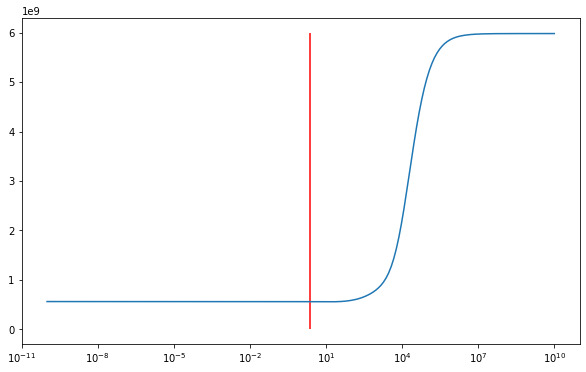

In [46]:
# Let's average the CV scores for each value of alpha
ridge_cv_means = [np.mean(cv_alpha) for cv_alpha in ridge_cv.cv_values_.T]
#plot
fig = plt.figure(figsize=(10,6))
ax = plt.gca()
ax.semilogx(ridge_cv.alphas, ridge_cv_means)
plt.vlines(x=np.log(11.357333583431075),ymin=0, ymax=6000000000, color='red');

We can see from our visualisation above that the alpha lies at the interception between the blue and red line.
The alpha is positioned quite to the middle part.

In [47]:
#Set best alpha
alpha = 11.357333583431075
#Instantiate Ridge model
ridge_model = Ridge(alpha=alpha)
#Cross validate Ridge model
ridge_MSE = - cross_val_score(ridge_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
print('Root Mean Squared Error is:', np.sqrt(ridge_MSE))

Root Mean Squared Error is: 23724.578941280775


### Lasso Model

In [48]:
#Instantiate LassoCV model
l_alphas = np.arange(0, 250, 10) 
lasso_cv = LassoCV(alphas=l_alphas, cv=5, max_iter=50000)

In [49]:
#Fit RidgeCV
lasso_cv.fit(X_train,y_train)

/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 314529568223.9092, tolerance: 720927594.2693266
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iteration

LassoCV(alphas=array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240]),
        cv=5, max_iter=50000)

In [50]:
#Check best alpha
lasso_cv.alpha_

70

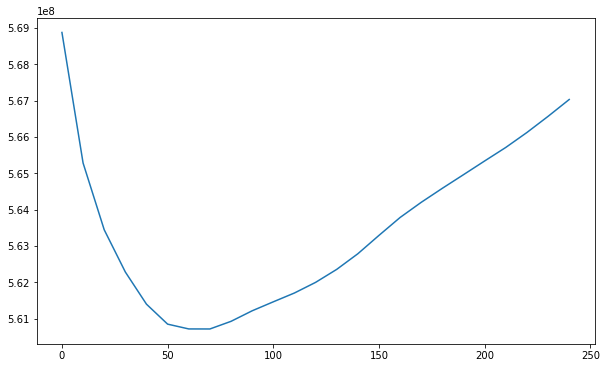

In [51]:
# Let's average the CV scores for each value of alpha
lasso_cv_means = [np.mean(cv_alpha) for cv_alpha in lasso_cv.mse_path_]
fig = plt.figure(figsize=(10,6))
ax = plt.gca()
ax.plot(lasso_cv.alphas_, lasso_cv_means);

Our best alpha value is 70, which is also at around the tip of the curvature, where the slop of the graph is 0

In [52]:
#Set best alpha
alpha = 70
#Instantiate Lasso model
lasso_model = Lasso(alpha=alpha)
#Cross validate Lasso model
lasso_MSE = - cross_val_score(lasso_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
print('Root Mean Squared Error is:', np.sqrt(lasso_MSE))

Root Mean Squared Error is: 23677.615478717165


In [53]:
#Check out our Lasso coefficients!
#There may be many predictors that have been zero-ed out
lasso_cv.coef_

array([  1782.1844264 ,   5910.0177706 ,  13122.64237334,   6841.81126474,
          591.29096439,   8687.78895237,   8389.81213116,   5205.86597029,
         7590.57519045,  16333.41428083,  -3022.15151255,    609.76765317,
         1839.09164628,   4969.26958525,    703.6806107 ,    354.38528161,
         2849.87466409,  -2000.03262047, -10284.11742638,    211.36165427,
           -0.        ,  -1958.93113538,  31242.50012187,  -3328.03497875,
           -0.        ,   2762.02087046,   8881.25956555,  34882.39401478,
         -814.79866059,   2044.89992635,  -2561.75840413,      0.        ,
            0.        ,   -124.49622505,     -0.        ,   1840.04071719,
         2606.1055767 ,  12646.15076531,  -1903.48886897,   -484.47033501,
        28778.34397247,     -0.        ,      0.        ,  -3215.36976593,
         2431.71786192,   1369.82326838,  -3602.85896713,   -563.9947156 ,
         2574.76229973,      0.        ,      0.        ,     -0.        ,
        -5189.97553798,  

### ElasticNet Model

In [54]:
#Instantiate EnetCV model
en_alphas = np.arange(0.001,1,0.005)
en_ratio = 0.5
en_cv = ElasticNetCV(alphas=en_alphas, l1_ratio=en_ratio, cv=5)

In [55]:
#Fit RidgeCV
en_cv.fit(X_train,y_train)

/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 237339848952.04703, tolerance: 720927594.2693266
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60067765389.65106, tolerance: 708306261.4127735
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5084574436.286682, tolerance: 776261915.8087174
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear

ElasticNetCV(alphas=array([0.001, 0.006, 0.011, 0.016, 0.021, 0.026, 0.031, 0.036, 0.041,
       0.046, 0.051, 0.056, 0.061, 0.066, 0.071, 0.076, 0.081, 0.086,
       0.091, 0.096, 0.101, 0.106, 0.111, 0.116, 0.121, 0.126, 0.131,
       0.136, 0.141, 0.146, 0.151, 0.156, 0.161, 0.166, 0.171, 0.176,
       0.181, 0.186, 0.191, 0.196, 0.201, 0.206, 0.211, 0.216, 0.221,
       0.226, 0.231, 0.236, 0.241, 0.246, 0.251, 0.256, 0.261, 0.266...
       0.676, 0.681, 0.686, 0.691, 0.696, 0.701, 0.706, 0.711, 0.716,
       0.721, 0.726, 0.731, 0.736, 0.741, 0.746, 0.751, 0.756, 0.761,
       0.766, 0.771, 0.776, 0.781, 0.786, 0.791, 0.796, 0.801, 0.806,
       0.811, 0.816, 0.821, 0.826, 0.831, 0.836, 0.841, 0.846, 0.851,
       0.856, 0.861, 0.866, 0.871, 0.876, 0.881, 0.886, 0.891, 0.896,
       0.901, 0.906, 0.911, 0.916, 0.921, 0.926, 0.931, 0.936, 0.941,
       0.946, 0.951, 0.956, 0.961, 0.966, 0.971, 0.976, 0.981, 0.986,
       0.991, 0.996]),
             cv=5)

In [56]:
#Check best alpha
en_cv.alpha_

0.016

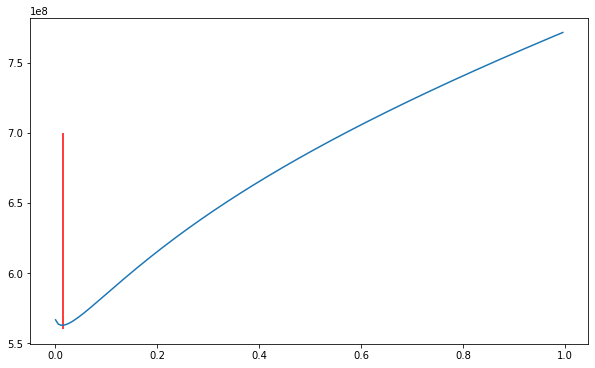

In [57]:
# Let's average the CV scores for each value of alpha
en_cv_means = [np.mean(cv_alpha) for cv_alpha in en_cv.mse_path_]
fig = plt.figure(figsize=(10,6))
ax = plt.gca()
ax.plot(en_cv.alphas, list(reversed(en_cv_means)))
plt.vlines(x=0.016,ymin=560000000, ymax=700000000, color='red');

Our best alpha is 0.016. Although it is very close to the edge, we can see that from our MSE that the curvature starts to curve at our best alpha!

In [58]:
#Set best alpha
alpha = 0.016
#Instantiate Ridge model
en_model = ElasticNet(alpha=alpha)
#Cross validate Ridge model
en_MSE = - cross_val_score(en_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
print('Root Mean Squared Error is:', np.sqrt(en_MSE))

Root Mean Squared Error is: 23721.000461386382


## Model Fit and Evaluate (with hold out set)

Now, we can evaluate our models above with our holdout set

### Linear Model

In [59]:
#Evaluate using our linear model on our holdout
#Predict
y_preds = lr.predict(X_holdout)

In [60]:
#Check our RMSE
print('Root Mean Squared Error is:', metrics.mean_squared_error(y_holdout,y_preds, squared=False))

Root Mean Squared Error is: 24990.92134161795


### Ridge Model

In [61]:
#Evaluate using our Ridge model on our holdout
#Fit and predict
ridge_model.fit(X_train,y_train)
y_preds2 = ridge_model.predict(X_holdout)

In [62]:
#Check our RMSE
print('Root Mean Squared Error is:', metrics.mean_squared_error(y_holdout,y_preds2, squared=False))

Root Mean Squared Error is: 24961.935966817993


### Lasso Model

In [63]:
#Evaluate using our Lasso model on our holdout
#Fit and predict
lasso_model.fit(X_train,y_train)
y_preds3 = lasso_model.predict(X_holdout)

In [64]:
#Check our RMSE
print('Root Mean Squared Error is:', metrics.mean_squared_error(y_holdout,y_preds3, squared=False))

Root Mean Squared Error is: 24999.117324247538


### ElasticNet Model

In [65]:
#Evaluate using our Lasso model on our holdout
#Fit and predict
en_model.fit(X_train,y_train)
y_preds4 = en_model.predict(X_holdout)

In [66]:
#Check our RMSE
print('Root Mean Squared Error is:', metrics.mean_squared_error(y_holdout,y_preds4, squared=False))

Root Mean Squared Error is: 24964.81335939127


## Observations & Discussions

Below is a summarized table that shows the result of our initial model (null) and regularized using Ridge, Lasso and ElasticNet.

<span style='color:blue'>Based on our training data, our Lasso model works the best, such that the root mean squared error (RMSE) metric is the lowest of all (23677). Thus, we will treat this Lasso model as our **production model**.<span>

| Model      | Train (RMSE) | Hold_Out (RMSE) |
|------------|-------|----------|
| Linear     | 23925 | 24990    |
| Ridge      | 23724 | 24961    |
| Lasso      | 23677 | 24999    |
| ElasticNet | 23721 | 24964    |

Although our Lasso model generated the best score in our training set, we can see that it did not perform too well in our hold_out set compared to other models, albeit with very tight differences!

We suspect that the model might be slightly overfitted to our training set, but the differences are too small to show a big gap in variance.

We will ignore these differences as our scoring should consider only the train set (as we can only control the train set and not the test set).

In [67]:
#Create a DF to show our coefficients
beta = pd.DataFrame()
#Predictors
beta['x(features)'] = X_holdout.columns
#Coefficients
beta['beta'] = lasso_model.coef_
#No. of coefficients zero-ed by Lasso
beta[beta['beta']==0].count()

x(features)    12
beta           12
dtype: int64

In [68]:
# PREDICTORS THAT ARE ZERO-ED!
beta[beta['beta']==0]['x(features)']

20    neighborhood_tier_five
24     neighborhood_tier_six
31             exter_cond_Ex
32             exter_cond_Fa
34             exter_cond_Po
41           kitchen_qual_Fa
42           kitchen_qual_Gd
49             heating_qc_Fa
50             heating_qc_Gd
51             heating_qc_Po
56         fireplace_qu_None
57           fireplace_qu_Po
Name: x(features), dtype: object

Thus, above 12 features are redundant in our Linear Regression model.  
<span style='color:blue'>**If we were to remove these, our model has 47 predictors (which covers 28 features of any house)**<span>

In [69]:
#See our coefficients
beta.sort_values(by='beta', ascending=False)

,x(features),beta
27,exter_qual_Ex,34882.394015
22,neighborhood_tier_one,31242.500122
40,kitchen_qual_Ex,28778.343972
9,gr_liv_area,16333.414281
2,overall_qual,13122.642373
37,bsmt_exposure_Gd,12646.150765
26,neighborhood_tier_two,8881.259566
5,bsmtfin_sf_1,8687.788952
6,total_bsmt_sf,8389.812131
8,sec_flr_sf,7590.575190


**What do we observe from our model coefficients**

1. The feature 'bedroom_abvgr' looks out of place, with a negative coefficient of -3022  
   We might expect the price to increase as the number of bedroom increases  
   Current suspect is because 'bedroom_abvgr' is correlated to another feature,      'totrms_abvgrd'. Corr score of 0.66
   
   
2. Earlier during EDA, we noticed that the correlation between 'totrms_abvgrd' and 'gr_liv_area' is also pretty high at 0.81. Coef score as below:  
   totrms_abvgrd - 609.767653  
   gr_liv_area - 16333.414281  
   
   **If two predictors are correlated and both are included in a model, one will be insignificant. In our case, 'totrm_abvgrd' can be further removed in our improvement plan.**
   


**12 zero-ed coefficients**

Our Lasso model penalized our linear model, shrinking 12 variables to 0.  
Thus we can infer that these 12 variables are not useful in our models and can be dropped in our future improvement plan.

**Limitations of our model**

Our model did perform quite well in generelizing to new data (best performance in all our iterations performed). However, we do not see this model being accurate if fitted into other cities' housing market.

Reason being:
- In general, our model can only be used to predict our target (sale price) at certain values of our independent variable (house features).  
  However, houses in other cities might have different overall house feature sizes and needs. For instance, a house in South East Asia do not require heating nor a basement!

We can try to 'globalize' our model via ways such as:
1. Identify only common house features / metrics to use in our model
2. Get more training data and perhaps we can include a column if the house is in which continent

## Further Improvements

This is our best score after several iterations of modelling!
Below is a summary table of the design process of our model:

| Summary                                           | Model       | Train RMSE | Hold-Out RMSE | Best Public Score RMSE in Kaggle |
|---------------------------------------------------|-------------|------------|---------------|------------------------|
| 22 predictors (from 13 different house features)  | Elastic Net | 28103      | 26604         | 31696                  |
| 15 predictors (from 11  different house features) | Lasso       | 30303      | 38076         | 33543                  |
| 30 predictors (from 17  different house features) | Lasso       | 26752      | 26152         | 30919                  |
| 34 predictors (from 17  different house features) | Lasso       | 26427      | 26089         | 30299                  |
| 48 predictors (from 25  different house features) | Ridge       | 25768      | 25272         | 29591                  |
|  Current Production Model                                         | Lasso       |  23677      |        24999  | 28799                       |

Over the first few iterations, our initial model was underfitting.  
The reason for this intuition is because as complexity arises, we can see that our predictions are getting better and better.

<u>Idea 1</u>  
**Try other / more features**

- Currently our production model is already generating our best scores ever, and one way we can keep on pushing is to add even more features in or trying different features
- Idea is to add even more features until the RMSE scores doesnt further improve (point where complexity is not useful anymore)
- Drawback is that our model might be too complex and even become overfit instead

<u>Idea 2</u>  
**Remove collinear features**

- One of our observations above was that 'totrm_abvgrd' had very low coef and was basically redundant and insignificant. 
- Our model is expected to perform better without collinear features

<u>Idea 3</u>  
**Perform further feature engineering**

Things that we can try:
- Reducing the tiers in neighborhood, so that the IQR overlap less
- Add up all SF (square feet) based variables (example: first_flr_sf and sec_flr_sf)
- Multiplying different features to see their interaction to the sale price

<u>Idea 4</u>  
**Use automated feature selection**

- Recursive feature elimination (RFE and RFECV)

## Conclusion & Recommendations

We will now go through our coefficient analysis! This will be where we answer our data science problem (recalled below)

1. What are the top 10 features most important to a house in Ames? 
2. What are the worst 3 features that will devalue a house?

In [70]:
#Top 10 coefficients (biggest)
beta.sort_values(by='beta', ascending=False).head(10)

,x(features),beta
27,exter_qual_Ex,34882.394015
22,neighborhood_tier_one,31242.500122
40,kitchen_qual_Ex,28778.343972
9,gr_liv_area,16333.414281
2,overall_qual,13122.642373
37,bsmt_exposure_Gd,12646.150765
26,neighborhood_tier_two,8881.259566
5,bsmtfin_sf_1,8687.788952
6,total_bsmt_sf,8389.812131
8,sec_flr_sf,7590.575190


**Features Most Important to a House**

As we can see above, the top ten coefficients are the top ten features that are most important to a house in Ames.

In short, a good house in Ames must have:

1. An excellent external quality
    - First impression matters!
2. Be located in a good neighborhood
    - Location! Location! Location!
    - A house staying in tier 1 area will generally be USD $22,361 more expensive than the tier 2
3. An excelent kitchen
   - Kitchen is a very important space to Americans
4. Huge ground living area
   - The bigger the house, the higher its value
5. Good overall quality
   - Materials and the finish of the house will influence the house buyers
6. Good basement exposure
   - Better with a walkout or garden level walls, for easy access
7. Big furnished basement 
   - Americans do use their basements as a living space, so space and furnishing is important
8. Big second floor level
   - The bigger the upper floor, the better it is

In [71]:
#Top 3 coefficients (most destructive to a house!)
beta.sort_values(by='beta', ascending=True).head(3)

,x(features),beta
18,built_age,-10284.117426
52,heating_qc_TA,-5189.975538
46,garage_finish_RFn,-3602.858967


**Features That Will Devalue a House**

To answer this question, we will take a look at the bottom 3 coefficients of negative value

The top 3 elements are:

1. Age of a house
   - Old houses are not as attractive as new ones! Also comes with a lot of issues to fix!
2. Poor heating quality and condition
   - Our model above had already zero-ed out all but 2 categories (Excellent and Average), thus TA is considered bad in this case
   - Generally, heating in especially important in countries with 4 seasons
3. Rough garage finish
   - A garage is also considered as an important space to most Americans. A poor finish will lessen the house value.

**What this will mean to all stakeholders**

<u>As a buyer</u>
- Buyers can use our model to calculate the market value of any given house in Ames after observing the house of interest
- This can help them to make wiser decisions!

<u>As a seller</u>
- Sellers can refer to our model to find ways that can push up the value of their home, and simultaneously avoid the bad characteristics of a house that have been identified by us!
- This way they will be able to maximise the value of their houses and earn more, especially if they are property flippers or are treating property as an investment vehicle.

<u>As a property developer / state housing department</u>
- Property developers or even the government can also use our model to 
    - influence the design of future houses
    - plan which location to build
      Tier1 house can command a better price, but if you want to solve affordable housing crisis, then pick other neighborhoods!
    - identify up and coming residential areas with high potential
    - make better decision and plan (to resolve affordable housing crisis)

## Final Kaggle Submission 

### Clean and Reapply Test Set

First of all, we will want to simplify and redo everything we have done so that our final test has the same format as our X_train above

In [72]:
#import data
dtest = pd.read_csv('../datasets/test.csv')

In [73]:
#Check null values in our test
dtest.isnull().sum().sort_values(ascending=False).head(20)

Pool QC           875
Misc Feature      838
Alley             821
Fence             707
Fireplace Qu      422
Lot Frontage      160
Garage Cond        45
Garage Qual        45
Garage Yr Blt      45
Garage Finish      45
Garage Type        44
Bsmt Exposure      25
BsmtFin Type 1     25
Bsmt Qual          25
BsmtFin Type 2     25
Bsmt Cond          25
Mas Vnr Area        1
Mas Vnr Type        1
Electrical          1
Overall Cond        0
dtype: int64

From here onwards, all actions will be trying to just reformat our test.csv to what we did previously. Comments may not be available
___

In [74]:
#Perform the same changes!
#No explanations provided because they are the same as our Part1 notebook
dtest.columns = dtest.columns.str.replace(' ','_').str.lower()

dtest.fillna('None', inplace=True)

dtest['lot_frontage'] = dtest['lot_frontage'].replace('None',0)
dtest['mas_vnr_area'] = dtest['mas_vnr_area'].replace('None',0)
    
for i in dtest.loc[dtest['garage_yr_blt'] == 'None'].index:
    dtest['garage_yr_blt'][i] = float(dtest['yr_sold'][i])

dtest['bsmt_exposure'] = dtest['bsmt_exposure'].replace('None','No')

dtest['electrical'] = dtest['electrical'].replace('None','Mix')

<ipython-input-74-b0321268a331>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtest['garage_yr_blt'][i] = float(dtest['yr_sold'][i])


In [75]:
#Check if any null values
dtest.isnull().sum().sum()

0

In [76]:
#Create a separate dataframe for our features to be fed into part 2 of feature engineering!
test = pd.DataFrame()
features = ['lot_frontage',
            'lot_area',
            'overall_qual',
            'overall_cond',
            'year_built',
            'year_remod/add',
            'yr_sold',
            'mas_vnr_area',
            'bsmtfin_sf_1',
            'total_bsmt_sf',
            '1st_flr_sf',
            '2nd_flr_sf',
            'gr_liv_area',
            'bsmt_full_bath',
            'bsmt_half_bath',
            'full_bath',
            'half_bath',
            'bedroom_abvgr',
            'totrms_abvgrd',
            'fireplaces',       
            'garage_area',
            'wood_deck_sf',
            'open_porch_sf',
            'screen_porch',
            'neighborhood',
            'exter_qual',
            'exter_cond',
            'bsmt_exposure',
            'kitchen_qual',
            'garage_finish',
            'heating_qc',
            'fireplace_qu']
for i in features:
    test[i] = dtest[i]

In [77]:
test.rename(columns={'1st_flr_sf':'frst_flr_sf','2nd_flr_sf':'sec_flr_sf'}, inplace=True)

test['remod_age'] = test['yr_sold'] - test['year_remod/add']
test['built_age'] = test['yr_sold'] - test['year_built']

In [78]:
test['total_bath'] = test['full_bath'] + test['half_bath'] + test['bsmt_full_bath'] + test['bsmt_half_bath']

test.drop(columns=['year_built','year_remod/add','yr_sold',
                    'full_bath','half_bath','bsmt_full_bath','bsmt_half_bath'], inplace=True)

In [79]:
test['neighborhood'] = test['neighborhood'].map({'Blmngtn':'tier_three',
       'Blueste':'tier_five',
       'BrDale':'tier_seven',
       'BrkSide':'tier_six',
       'ClearCr':'tier_two',
       'CollgCr':'tier_three',
       'Crawfor':'tier_three',
       'Edwards':'tier_six',
       'Gilbert':'tier_four',
       'Greens':'tier_four',
       'GrnHill':'tier_one',
       'IDOTRR':'tier_seven',
       'Landmrk':'tier_six',
       'MeadowV':'tier_seven',
       'Mitchel':'tier_four',
       'NAmes':'tier_five',
       'NoRidge':'tier_one',
       'NPkVill':'tier_five',
       'NridgHt':'tier_one',
       'NWAmes':'tier_three',
       'OldTown':'tier_seven',
       'SWISU':'tier_six',
       'Sawyer':'tier_five',
       'SawyerW':'tier_four',
       'Somerst':'tier_two',
       'StoneBr':'tier_one',
       'Timber':'tier_two',
       'Veenker':'tier_two'})

In [80]:
test_scaled_columns = ss.transform(test[columns_to_scale])
test_scale_part = pd.DataFrame(test_scaled_columns, columns = columns_to_scale)

test_encode_part = test[columns_to_encode]
test_encode_part = pd.get_dummies(test_encode_part, columns=columns_to_encode) 
test_encode_part = test_encode_part.reset_index(drop=True)

test = pd.concat([test_scale_part, test_encode_part], axis=1)

We have completed all actions!
____

In [81]:
#Check out the test DF
test.head()

,lot_frontage,lot_area,overall_qual,overall_cond,mas_vnr_area,bsmtfin_sf_1,total_bsmt_sf,frst_flr_sf,sec_flr_sf,gr_liv_area,bedroom_abvgr,totrms_abvgrd,fireplaces,garage_area,wood_deck_sf,open_porch_sf,screen_porch,remod_age,built_age,total_bath,neighborhood_tier_five,neighborhood_tier_four,neighborhood_tier_one,neighborhood_tier_seven,neighborhood_tier_six,...,exter_cond_Po,exter_cond_TA,bsmt_exposure_Av,bsmt_exposure_Gd,bsmt_exposure_Mn,bsmt_exposure_No,kitchen_qual_Ex,kitchen_qual_Fa,kitchen_qual_Gd,kitchen_qual_Po,kitchen_qual_TA,garage_finish_Fin,garage_finish_None,garage_finish_RFn,garage_finish_Unf,heating_qc_Ex,heating_qc_Fa,heating_qc_Gd,heating_qc_TA,fireplace_qu_Ex,fireplace_qu_Fa,fireplace_qu_Gd,fireplace_qu_None,fireplace_qu_Po,fireplace_qu_TA
0,0.341259,-0.151569,-0.082961,2.223448,-0.570252,-0.999551,-0.072759,-0.667284,1.632478,0.908639,1.404314,1.710077,-0.931971,-0.173679,-0.742755,0.188589,-0.283780,1.551296,2.002069,-0.47838,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
1,-1.749307,-0.042418,-0.788132,-1.456244,-0.570252,-0.999551,2.123468,2.136351,-0.767540,0.990075,3.810361,2.369956,-0.931971,0.478965,0.590384,-0.706992,-0.283780,0.261489,-0.227309,-0.47838,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0
2,0.007980,1.519706,0.622210,-0.536321,-0.570252,0.254565,-0.921564,-1.313258,1.190122,0.006578,0.201290,0.390320,0.648867,-0.238943,0.041445,-0.348760,-0.283780,-1.123858,-1.192264,1.66174,0,1,0,0,0,...,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
3,0.068577,-0.282131,-0.788132,0.383602,-0.570252,-0.999551,-0.193354,-0.508437,-0.767540,-1.095941,-1.001733,-0.929437,-0.931971,0.012791,-0.742755,-0.706992,-0.283780,-1.076088,1.602777,-1.54844,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0
4,-1.749307,-0.076422,-0.082961,-0.536321,0.879088,0.379071,0.794600,0.619370,-0.767540,-0.206408,0.201290,-0.269558,2.229705,0.171290,-0.742755,0.427411,2.970831,1.073590,0.338354,0.59168,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0


In [82]:
#Compare to our modelling X_train, to see if any difference
X_train.head()

,lot_frontage,lot_area,overall_qual,overall_cond,mas_vnr_area,bsmtfin_sf_1,total_bsmt_sf,frst_flr_sf,sec_flr_sf,gr_liv_area,bedroom_abvgr,totrms_abvgrd,fireplaces,garage_area,wood_deck_sf,open_porch_sf,screen_porch,remod_age,built_age,total_bath,neighborhood_tier_five,neighborhood_tier_four,neighborhood_tier_one,neighborhood_tier_seven,neighborhood_tier_six,...,exter_cond_Po,exter_cond_TA,bsmt_exposure_Av,bsmt_exposure_Gd,bsmt_exposure_Mn,bsmt_exposure_No,kitchen_qual_Ex,kitchen_qual_Fa,kitchen_qual_Gd,kitchen_qual_TA,garage_finish_Fin,garage_finish_None,garage_finish_RFn,garage_finish_Unf,heating_qc_Ex,heating_qc_Fa,heating_qc_Gd,heating_qc_Po,heating_qc_TA,fireplace_qu_Ex,fireplace_qu_Fa,fireplace_qu_Gd,fireplace_qu_None,fireplace_qu_Po,fireplace_qu_TA
0,-1.022154,-1.536531,-0.082961,-0.536321,0.697187,-0.148382,-1.046798,-1.482694,0.728942,-0.536329,-1.001733,-1.589315,-0.931971,0.012791,-0.742755,1.770782,-0.28378,-0.885005,-1.025892,1.66174,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
1,-1.749307,0.433440,1.327381,1.303525,2.164131,-0.999551,0.442090,0.240787,2.173659,2.105123,1.404314,1.710077,0.648867,1.276123,0.762908,0.591601,-0.28378,-0.502840,-0.759698,0.59168,0,0,1,0,0,...,0,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1
2,0.068577,0.007540,-0.082961,1.303525,-0.570252,-0.999551,-0.633991,-0.571976,0.514823,-0.008039,0.201290,0.390320,0.648867,-1.106028,1.884313,-0.706992,-0.28378,1.694608,1.103663,-0.47838,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0
3,-0.173808,-0.760717,-0.788132,2.223448,-0.570252,-0.890891,-0.879820,-0.691110,0.227762,-0.356752,1.404314,0.390320,-0.931971,-0.919558,-0.742755,-0.706992,-0.28378,1.503525,1.070388,-0.47838,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0
4,-1.749307,1.048676,1.327381,-0.536321,0.838014,2.482092,1.685150,1.657165,-0.767540,0.612128,0.201290,-0.269558,0.648867,1.108301,0.684488,-0.184570,-0.28378,-0.885005,-0.992618,0.59168,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0


In [83]:
#Check what is extra in our test set
for i in test.columns:
    if i not in X_train.columns:
        print (i)

kitchen_qual_Po


In [84]:
#Check what is extra in our train set
for i in X_train.columns:
    if i not in test.columns:
        print (i)

heating_qc_Po


**Although the shape of our test set and X_train set are the same (# of columns aligned), there is 1 feature that exists only in our training set ('heating_qc_Po') and 1 feature that exists only in our test set ('kitchen_qual_Po').**

**For 'kitchen_qual_Po', we have to remove this column. Reason is because we did not have this in our training set, and our linear model does not have the coefficient for this variable.  
Thus the relationship (or coefficient) to the sale price is unknown!**

We will remove this and add in 1 column (heating_qc_Po) into our test set

In [85]:
#Add columns
test['heating_qc_Po'] = 0
#drop columns
test.drop(columns='kitchen_qual_Po', inplace=True)

In [86]:
#Reassign the columns!
test = test[X_train.columns]

In [87]:
#Check
test.head()

,lot_frontage,lot_area,overall_qual,overall_cond,mas_vnr_area,bsmtfin_sf_1,total_bsmt_sf,frst_flr_sf,sec_flr_sf,gr_liv_area,bedroom_abvgr,totrms_abvgrd,fireplaces,garage_area,wood_deck_sf,open_porch_sf,screen_porch,remod_age,built_age,total_bath,neighborhood_tier_five,neighborhood_tier_four,neighborhood_tier_one,neighborhood_tier_seven,neighborhood_tier_six,...,exter_cond_Po,exter_cond_TA,bsmt_exposure_Av,bsmt_exposure_Gd,bsmt_exposure_Mn,bsmt_exposure_No,kitchen_qual_Ex,kitchen_qual_Fa,kitchen_qual_Gd,kitchen_qual_TA,garage_finish_Fin,garage_finish_None,garage_finish_RFn,garage_finish_Unf,heating_qc_Ex,heating_qc_Fa,heating_qc_Gd,heating_qc_Po,heating_qc_TA,fireplace_qu_Ex,fireplace_qu_Fa,fireplace_qu_Gd,fireplace_qu_None,fireplace_qu_Po,fireplace_qu_TA
0,0.341259,-0.151569,-0.082961,2.223448,-0.570252,-0.999551,-0.072759,-0.667284,1.632478,0.908639,1.404314,1.710077,-0.931971,-0.173679,-0.742755,0.188589,-0.283780,1.551296,2.002069,-0.47838,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
1,-1.749307,-0.042418,-0.788132,-1.456244,-0.570252,-0.999551,2.123468,2.136351,-0.767540,0.990075,3.810361,2.369956,-0.931971,0.478965,0.590384,-0.706992,-0.283780,0.261489,-0.227309,-0.47838,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,0.007980,1.519706,0.622210,-0.536321,-0.570252,0.254565,-0.921564,-1.313258,1.190122,0.006578,0.201290,0.390320,0.648867,-0.238943,0.041445,-0.348760,-0.283780,-1.123858,-1.192264,1.66174,0,1,0,0,0,...,0,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0
3,0.068577,-0.282131,-0.788132,0.383602,-0.570252,-0.999551,-0.193354,-0.508437,-0.767540,-1.095941,-1.001733,-0.929437,-0.931971,0.012791,-0.742755,-0.706992,-0.283780,-1.076088,1.602777,-1.54844,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
4,-1.749307,-0.076422,-0.082961,-0.536321,0.879088,0.379071,0.794600,0.619370,-0.767540,-0.206408,0.201290,-0.269558,2.229705,0.171290,-0.742755,0.427411,2.970831,1.073590,0.338354,0.59168,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0


### Rescale and Refit Entire Train Set (whole train.csv)

We want to use the entire train.csv and fit into our model.  

Reason: We want to have more sample set to increase accuracy

In [88]:
#Set X, y from our whole train part (train.csv)
y = train['saleprice']
X_to_scale = train[columns_to_scale]
X_to_encode = train[columns_to_encode]

In [89]:
# Scale for (columns_to_scale) for train and holdout
ss = StandardScaler()
scale_data = ss.fit_transform(X_to_scale)
# Make into df
X_scale_part = pd.DataFrame(scale_data, columns = columns_to_scale)

In [90]:
#Perform encode to our encode_part
X_encode_part = pd.get_dummies(X_to_encode, columns=columns_to_encode) 
X_encode_part = X_encode_part.reset_index(drop=True)

In [91]:
# X will be our X_train!
X = pd.concat([X_scale_part, X_encode_part], axis=1)

In [92]:
#Check X
X.head()

,lot_frontage,lot_area,overall_qual,overall_cond,mas_vnr_area,bsmtfin_sf_1,total_bsmt_sf,frst_flr_sf,sec_flr_sf,gr_liv_area,bedroom_abvgr,totrms_abvgrd,fireplaces,garage_area,wood_deck_sf,open_porch_sf,screen_porch,remod_age,built_age,total_bath,neighborhood_tier_five,neighborhood_tier_four,neighborhood_tier_one,neighborhood_tier_seven,neighborhood_tier_six,...,exter_cond_Po,exter_cond_TA,bsmt_exposure_Av,bsmt_exposure_Gd,bsmt_exposure_Mn,bsmt_exposure_No,kitchen_qual_Ex,kitchen_qual_Fa,kitchen_qual_Gd,kitchen_qual_TA,garage_finish_Fin,garage_finish_None,garage_finish_RFn,garage_finish_Unf,heating_qc_Ex,heating_qc_Fa,heating_qc_Gd,heating_qc_Po,heating_qc_TA,fireplace_qu_Ex,fireplace_qu_Fa,fireplace_qu_Gd,fireplace_qu_None,fireplace_qu_Po,fireplace_qu_TA
0,-1.779126,0.820026,-0.075171,2.203291,1.122482,0.221363,-0.766716,-1.148312,1.000525,-0.029675,0.189725,-0.276145,-0.924880,0.014349,-0.729044,-0.046338,-0.286868,-0.886816,-0.070107,0.605131,1,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
1,-0.458602,0.377663,0.628606,-0.509508,0.204268,0.458274,-0.324533,-0.650775,2.071493,1.298173,1.399812,1.022500,0.658744,0.406259,-0.729044,0.409814,-0.286868,-0.553730,-0.764876,1.672609,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1
2,0.309145,-0.402206,-0.778948,1.299024,-0.567734,0.672405,0.014161,-0.269682,-0.774221,-0.901140,0.189725,-0.925467,-0.924880,-1.054073,-0.729044,0.075303,-0.286868,-0.981984,0.690830,-0.462347,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
3,0.462694,0.008481,-0.778948,-0.509508,-0.567734,-0.992807,-1.568761,-1.098029,0.873421,-0.101953,0.189725,0.373178,-0.924880,-0.335571,0.053403,-0.715360,-0.286868,-0.981984,-1.062634,0.605131,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,0.739083,0.976873,-0.075171,2.203291,-0.567734,-0.992807,-0.881966,-0.867786,0.670997,-0.099888,0.189725,-0.276145,-0.924880,0.056339,-0.729044,0.181738,-0.286868,-0.315811,2.444294,-0.462347,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0


In [93]:
#Run code to check if column sequence is same and if any columns missing
for i in range(len(X.columns)):
    if X.columns[i] != test.columns[i]:
        print ('Something is wrong')

Now that X,y is correctly scaled and defined, we can proceed to our modelling!

In [94]:
#Evaluate using our Lasso model on our test
#Fit and predict
lasso_model.fit(X,y)
preds = lasso_model.predict(test)

In [95]:
#Create the DF that we will submit to Kaggle
finalsample = pd.DataFrame()
#Copy the Id from the test.csv
finalsample['Id'] = dtest['id']
#Set SalePrice as our predictions
finalsample['SalePrice'] = preds
#Reset index
finalsample.set_index('Id', inplace=True)
#Check our DF
finalsample

,SalePrice
Id,
2658,160477.466290
2718,165934.779842
2414,201576.933949
1989,102903.569667
625,173184.784469
...,...
1662,191671.852475
1234,222139.313207
1373,123902.661242


In [96]:
#Save out to FinalKaggleSubmission
finalsample.to_csv('../datasets/FinalKaggleSubmission.csv')

Our final score in the Kaggle Competition is as below:

<span style='color:blue'>**Private Score : 31194.29992**<span>  
**Public Score  : 28799.35619**